# Model training

## Import libraries

The following command must be executed for balancing:

```conda install -c conda-forge imbalanced-learn```

In [1]:
%pip install -q -U imbalanced-learn

/bin/bash: /home/smol/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


In [1]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import BernoulliRBM

import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import numpy as np
import math

In [2]:
# Tensorflow may not be installed on every system

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from scikeras.wrappers import KerasClassifier

2022-11-25 10:01:22.952018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 10:01:24.682199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/smol/anaconda3/envs/tf/lib/
2022-11-25 10:01:24.682431: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/smol/anaconda3/envs/tf/lib/
2022-11-25 10:01:24.682439: W tensorflow/compiler/tf2tensorr

## Methods

In [4]:
def truncate(number, digits) -> float:
    # Helper method that truncate scores to four decimals
    nbDecimals = len(str(number).split('.')[1])
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper


def get_nested(data, *args):
    # Helper method that returns the value of a nested dictionary
    if args and data:
        element  = args[0]
        if element:
            value = data.get(element)
            return value if len(args) == 1 else get_nested(value, *args[1:])
    return None


def get_scores(y_test, y_predicted):
    # Method that returns different scores for the passed parameters
    digits = 4
    scores = {
        'Accuracy': truncate(accuracy_score(y_test, y_predicted), digits),
        'Recall': truncate(recall_score(y_test, y_predicted), digits),
        'Precision': truncate(precision_score(y_test, y_predicted), digits),
        'F1 score': truncate(f1_score(y_test, y_predicted), digits),
        'F2 score': truncate(fbeta_score(y_test, y_predicted, beta=2), digits)
    }
    return scores


def print_scores(all_scores):
    # Method that prints a table of the passed scores
    header_row = "{header:<20}".format(header="Estimator")
    for score in list(all_scores.values())[0]:
        header_row+="{header:>15}".format(header=score)
    print(header_row,"\n")

    for estimator in all_scores.keys():
        current_row = "{estimator:<20}".format(estimator=estimator)
        estimator_scores = all_scores.get(estimator)
        for score in estimator_scores:
            score_value = get_nested(all_scores, estimator, score)
            current_row+="{score_value:>15}".format(score_value=score_value)
        print(current_row)
        

def print_best_params(estimator_params):
    # Method that prints the best parameters
    for estimator in estimator_params.keys():
        print("Best parameters for "+estimator+": ")
        parameters = estimator_params.get(estimator)
        for parameter in parameters:
            print(parameter+": "+str(get_nested(estimator_params, estimator, parameter)))
            

def plot_roc(title, ax, y_test, y_predicted):
    # Method that plots the ROC for the passed parameters
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

    ax.set_title('Receiver Operating Characteristic (ROC) - '+title)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    

def plot_feature_importance(title, ax, estimator, X_train):
    # Method that plots the feature importance for the passed parameters
    feat_importance = pd.Series(estimator.feature_importances_, index=X_train.columns)
    feat_importance.nlargest(12).plot(kind='barh', ax=ax)

    ax.set_title('Feature Importance for '+title)


def plot_learning_curve(title, estimator, ax, X, y, cv, scoring):
    # Method that plots the learning curve for the passed parameters
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=4,
        train_sizes=np.linspace(0.1, 1.0, 5),
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

    ax.set_title("Learning Curve: "+title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend()
    

def model_evaluate(estimator, parameters, X_train, X_test, y_train, y_test):
    # Method that trains the passed model with the passed parameters and plots the evaluation of it
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    scoring = make_scorer(fbeta_score, beta=2)

    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator.value,
                                         param_grid=parameters,
                                         scoring= scoring,
                                         cv=cv,
                                         return_train_score=False,
                                         verbose=0,
                                         n_jobs=4
                                         )
    # training and prediction
    grid_search_estimator.fit(X_train, y_train)
    y_predicted = grid_search_estimator.predict(X_test)

    # evaluation of the model
    # TODO BL: @FL @JG should we use cross validation?
    print_scores({estimator.name: get_scores(y_test, y_predicted)})
    print_best_params({estimator.name: grid_search_estimator.best_params_})

    figure = plt.figure(figsize=(15, 15))
    figure_index = 1
    number_of_rows = 2
    number_of_columns = 2

    # plot roc
    ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
    plot_roc(title=estimator.name, ax=ax, y_test=y_test, y_predicted=y_predicted)
    figure_index += 1

    # plot feature importance in case of forest estimator
    if estimator==Estimator.forest_estimator:
        ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_feature_importance(title=estimator.name, ax=ax, estimator=grid_search_estimator.best_estimator_, X_train=X_train)
        figure_index += 1

    # plot learning curve in case of nn estimator
    if estimator==Estimator.nn_estimator:
        ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_learning_curve(title=estimator.name, estimator=estimator.value, ax=ax, X=X_train, y=y_train, cv=cv, scoring=scoring)
        figure_index += 1

    plt.show()

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [5]:
# Load dataset
heart_dataset = pd.read_csv('./heart_dataset_preprocessed.csv')

# Split and reduce dataset (reduction only for test purposes)
X = heart_dataset.drop(columns='HeartDisease')
y = heart_dataset['HeartDisease']
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.99, random_state = 42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.20, random_state = 42, stratify=y_train)

# Balance training data
X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

data_dict = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
X_train

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Diabetic,...,SleepTime,Asthma,KidneyDisease,SkinCancer,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White
0,0.137390,1,0,0,0.000000,0.0,0,0,72,0.0,...,0.304348,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.141615,1,1,0,0.000000,0.1,0,0,42,0.0,...,0.304348,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.211397,1,0,0,0.000000,0.0,0,0,47,1.0,...,0.260870,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.195219,0,0,0,0.000000,0.1,0,1,67,1.0,...,0.304348,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.215381,0,0,0,0.333333,0.0,0,0,67,1.0,...,0.173913,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4671,0.194978,0,0,0,1.000000,0.0,0,0,67,1.0,...,0.217391,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4672,0.172522,0,0,0,0.000000,0.0,0,0,90,0.0,...,0.260870,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0
4673,0.222504,0,0,0,0.000000,0.0,1,1,72,1.0,...,0.173913,0,0,0,0.0,0.0,0.0,1.0,0.0,0.0
4674,0.165761,1,0,0,0.000000,0.0,0,1,67,0.0,...,0.304348,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

Dummy Classifier             0.5031         0.5272         0.0903         0.1542          0.268


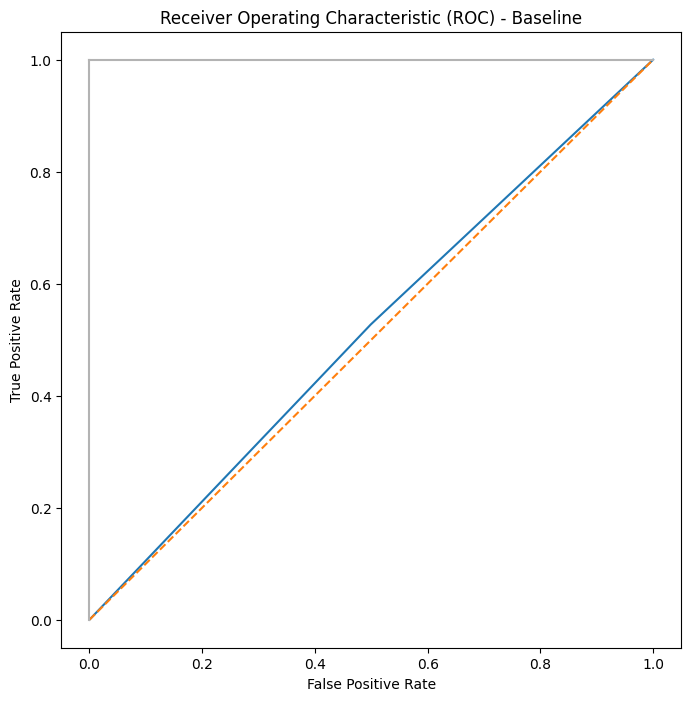

In [6]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_predicted = dummy_classifier.predict(X_test)

print_scores({'Dummy Classifier':get_scores(y_test, y_predicted)})
plot_roc(title='Baseline', ax=plt.figure(figsize=(8, 8)).add_subplot(), y_test=y_test, y_predicted=y_predicted)
plt.show()

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Model selection

To find out which modeling method with which parameters best fits to our task, we define a set of modeling methods, train them with different parameters (hyperparameter tuning) and evaluate the results.

In [7]:
# Create DNN model
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(30, input_shape=(X_train.columns.size,), activation='relu'))
    #model.add(Dense(30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Enumeration class containing all estimators we want to consider for classification
class Estimator(Enum):
    knn_estimator=KNeighborsClassifier()
    nn_estimator=MLPClassifier(random_state=1)
    forest_estimator=RandomForestClassifier()
    svc_estimator=SVC(random_state=0)
    dnn_estimator=KerasClassifier(model=create_model, verbose=0)

# TODO JG: Adjust nn parameters
# Dictionary of parameter grids of the estimators
param_grids = {
    Estimator.knn_estimator: {
        'n_neighbors': [2, 3, 4, 5]
    },
    Estimator.forest_estimator: {
        'class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:4}, {0:2, 1:1}],
        'n_estimators': [20, 50, 100, 200, 400, 800, 1000]
    },
    Estimator.svc_estimator: {
        'kernel': ['linear', 'poly']
    },
    Estimator.nn_estimator: {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'hidden_layer_sizes': [(100), (150,100,50), (120,80,40), (100,50,30)],
        'max_iter': [300, 400, 500, 600],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant','adaptive'],
    },
    Estimator.dnn_estimator: {
        'batch_size': [40, 60, 80, 100],
        'epochs': [1, 2, 5]
    }
}

In [8]:
# dnn estimator
estimator = Estimator.dnn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

2022-11-25 10:14:38.106142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 10:14:38.130959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 10:14:38.133028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the ap

2022-11-25 10:14:41.389681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-25 10:14:41.390591: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-25 10:14:41.390646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1700] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2022-11-25 10:14:41.390719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-11-25 10:14:41.391216: I tensorflow/core/common_runtime/gpu/gpu_device.c

2022-11-25 14:09:48.576252: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 14:09:48.601691: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 14:09:50.967150: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 14:09:51.002551: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 14:09:53.083268: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 14:09:53.162754: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:4

2022-11-25 14:35:58.658946: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 14:35:58.714429: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 14:39:02.840834: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 14:39:03.066755: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 14:39:05.136560: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 14:39:05.276601: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:4

2022-11-25 14:53:21.885617: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 14:53:21.975803: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 14:58:31.734043: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 14:58:32.157717: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 14:58:37.069135: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 14:58:37.085850: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:4

2022-11-25 15:14:55.061817: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 15:14:55.148357: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 15:25:18.861632: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 15:25:19.111419: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 15:25:25.386146: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 15:25:25.510919: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:4

2022-11-25 15:42:25.184970: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 15:42:25.232343: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 15:42:31.223588: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 15:42:32.057823: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 15:42:43.352112: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 15:42:43.485647: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:4

2022-11-25 16:11:43.705142: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 16:11:43.767949: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 16:11:47.765561: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 16:11:47.786637: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 16:11:53.002029: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 16:11:53.098510: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:4

2022-11-25 16:26:41.970569: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 16:28:33.378530: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 16:28:34.235366: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 16:28:39.405941: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 16:28:39.446476: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 16:31:48.066622: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by

2022-11-25 16:54:13.226508: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 16:54:13.354426: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 16:56:20.098169: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 16:56:20.892416: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 16:56:30.877028: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 16:56:31.062397: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:4

2022-11-25 17:16:55.684533: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 17:16:55.685390: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 17:16:55.708006: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 17:16:55.708478: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:446 : INTERNAL: libdevice not found at ./libdevice.10.bc
2022-11-25 17:16:55.734859: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:326] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2022-11-25 17:16:55.735375: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:4

ValueError: 
All the 48 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_810]

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_1619]

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_2428]

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_3237]

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_4046]

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_4855]

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_5664]

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_6473]

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_7282]

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_8091]

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_8900]

--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_9709]

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
    self._fit(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
    self._fit_keras_model(
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
    hist = self.model_.fit(x=X, y=y, **fit_args)
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/backend/popen_loky_posix.py", line 170, in <module>
      exitcode = process_obj._bootstrap()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
      self.run()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/multiprocessing/process.py", line 108, in run
      self._target(*self._args, **self._kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 428, in _process_worker
      r = call_item()
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 275, in __call__
      return self.fn(*self.args, **self.kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 620, in __call__
      return self.func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in __call__
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/joblib/parallel.py", line 288, in <listcomp>
      return [func(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/utils/fixes.py", line 117, in __call__
      return self.function(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
      estimator.fit(X_train, y_train, **fit_params)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 1494, in fit
      super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 762, in fit
      self._fit(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 931, in _fit
      self._fit_keras_model(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/scikeras/wrappers.py", line 526, in _fit_keras_model
      hist = self.model_.fit(x=X, y=y, **fit_args)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/smol/anaconda3/envs/tf/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1211, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_10518]


Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

knn_estimator                0.8746         0.2189         0.2429         0.2303         0.2233
Best parameters for knn_estimator: 
n_neighbors: 2


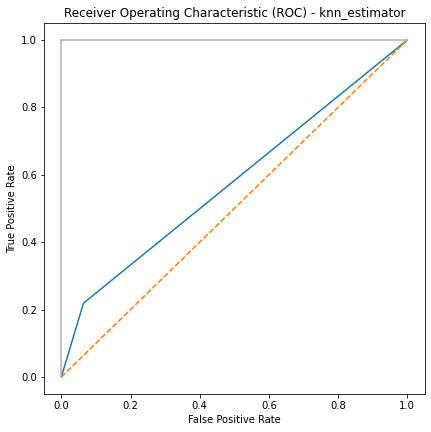

In [9]:
# knn estimator
estimator = Estimator.knn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)
plt.show()

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

forest_estimator             0.9102         0.1824         0.4424         0.2583         0.2067
Best parameters for forest_estimator: 
class_weight: {0: 1, 1: 2}
n_estimators: 800


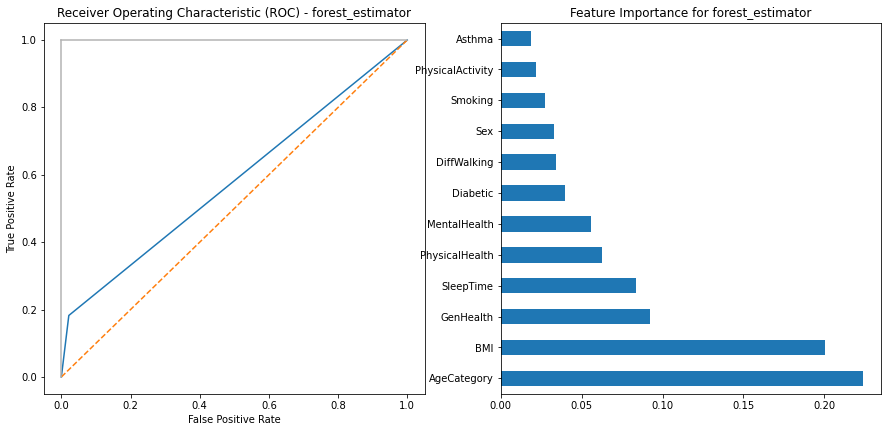

In [13]:
# random forest estimator
estimator = Estimator.forest_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [8]:
# nn estimator
estimator = Estimator.nn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\jonas\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITE

KeyboardInterrupt: 

In [25]:
# svc estimator
# estimator = Estimator.svc_estimator
# model_evaluate(estimator, param_grids.get(estimator), **data_dict)

**Conclusion**

TODO: Add conclusion

## Final model

After having determined the best model and the best parameters for it in the step of model selection, we now apply this in the following.

In [26]:
## TODO implement